In [11]:
import sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import backend as K
from tqdm import tqdm
from numpy.linalg import eig
from sklearn.decomposition import PCA

# reserve only the 30% of the GPU memory
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [7]:
batch_size = 512
width = 50
height = 10
channels = 4 #3
classes = 4
epochs = 100
dataset_dir = '/data/user/adipilat/ParticleID/genEvts/'
save_dir = '/data/user/adipilat/ParticleID/models/'
sample_dir = '/data/user/adipilat/ParticleID/sample_images/'
padding = 'padding' + str(height)
model_name= padding +'_PCAModel'
history_name = model_name + '_history'

# This dictionary should be extended to new classes and antiparticles
class_labels = {22:0, 11:1, 13:2, 211:3}

In [9]:
# arrays of data needed for training

data_array = []
pid_array = []
en_array = []

# read dataset
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]

for name in tqdm(files):
    print("Reading file", name)
    data = pd.read_hdf(dataset_dir + name)
    n_events = int(0.9 * data.event.max()) # using 90% of events for training

    for i in range(1, int(n_events+1)):
        tracksters = data.loc[(data['event'] == float(i)) & (data['trackster'] != float(0))]
        n_tracksters = tracksters.trackster.max()
        lead_en = 0
        for j in range(1, int(n_tracksters)+1):
            layerclusters = tracksters.loc[tracksters['trackster'] == float(j)]
            en = np.sum(layerclusters["E"].values)
            if(en>lead_en): #### since I shooted a single particle, only the leading trackster is considered
                lead_en = en
                image = np.zeros(width*height*channels).reshape(width,height,channels)
                pid = int(layerclusters["pid"].iloc[0])
                pid = class_labels[pid]
                en_value = layerclusters["genE"].iloc[0]
                for k in range(1, width+1):
                    layer = layerclusters[layerclusters['layer'] == float(k)]
                    if(len(layer) != 0):
                        temp = layer.E.values, layer.eta.values, layer.phi.values
                        temp = np.array(temp).T
                        dim = min(temp.shape[0],height)
                        image[k-1][:dim] = temp[:dim]
        data_array.append(image)
        pid_array.append(pid)
        en_array.append(en_value)    

    print("File", name, " processed")

data_array = np.array(data_array)
pid_array = np.array(pid_array)
pid_array = keras.utils.to_categorical(pid_array, num_classes=classes, dtype='float32')
en_array = np.array(en_array)

  0%|          | 0/4 [00:00<?, ?it/s]

Reading file gamma.h5


 25%|██▌       | 1/4 [16:14<48:42, 974.27s/it]

File gamma.h5  processed
Reading file electron.h5


 50%|█████     | 2/4 [33:02<32:48, 984.46s/it]

File electron.h5  processed
Reading file muon.h5


 75%|███████▌  | 3/4 [38:32<13:08, 788.09s/it]

File muon.h5  processed
Reading file pion_c.h5


100%|██████████| 4/4 [57:10<00:00, 887.24s/it]

File pion_c.h5  processed


In [10]:
print(data_array.shape)
# print(en_array.shape)
# print(pid_array.shape)
# print(data_array)

(36000, 50, 10, 4)


In [6]:
####### NORMALIZE THE ENERGY ########

mean_en = np.mean(en_array)
std_en = np.std(en_array)
print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_array_norm = (en_array - mean_en)/std_en

Mean Energy Value: 213.90352475881576
Std Energy Value: 108.05413626100672


In [44]:
print('Creating model...')

def tree_model():

    input_img = Input(shape=(width, height, channels), name='input')
    
    conv = Conv2D(3, (5,1), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv1')(input_img)
    conv = Conv2D(3, (3,3), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv2')(conv)
    conv = Conv2D(3, (3,3), activation='relu', padding='same', kernel_initializer='random_uniform', data_format='channels_last', name='conv3')(conv)

    flat = Flatten()(conv)

    dense = Dense(512, activation='relu', kernel_initializer='random_uniform', name='dense1')(flat)
#     drop = Dropout(0.5)(dense)
    dense = Dense(128, activation='relu', kernel_initializer='random_uniform', name='dense2')(dense)
#     drop = Dropout(0.5)(dense)
#     dense = Dense(256, activation='relu', kernel_initializer='random_uniform', name='dense3')(drop)

    dense_id = Dense(64, activation='relu', kernel_initializer='random_uniform', name='dense_id1')(dense)
#     drop = Dropout(0.5)(dense_id)
    dense_id = Dense(16, activation='relu', kernel_initializer='random_uniform', name='dense_id2')(dense_id)
#     drop = Dropout(0.5)(dense_id)

    pid = Dense(classes, activation='softmax', kernel_initializer='random_uniform', name='pid_output')(dense_id)

    dense_er = Dense(64, activation='relu', kernel_initializer='random_uniform', name='dense_er1')(dense)
    dense_er = Dense(16, activation='relu', kernel_initializer='random_uniform', name='dense_er2')(dense_er)

    dense_er_pid = Dense(classes, name='dense_er_pid')(dense_id)
    
    dense_er = Dense(1, name='dense_er3')(dense_er)
    
    conc = Concatenate()([dense_er_pid, dense_er])
    bnorm = BatchNormalization()(conc)
    enreg = Dense(1, name='enreg_output')(bnorm) #(dense_er)

    model = Model(inputs=input_img, outputs=[pid, enreg])

    model.compile(loss={'pid_output': 'categorical_crossentropy', 'enreg_output': 'mse'}, loss_weights={'pid_output': 1, 'enreg_output': 1}, optimizer='adam', metrics={'pid_output': 'accuracy', 'enreg_output': 'mse'})
    return model

model = tree_model()
model.summary()

print("Model created!")

Creating model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 10, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 10, 3)    48          input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 10, 3)    84          conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 50, 10, 3)    84          conv2[0][0]                      
___________________________________________________________________________________________

In [45]:
history = model.fit(data_array, {'pid_output': pid_array, 'enreg_output': en_array_norm}, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)], shuffle=True, verbose=1)
history_save = pd.DataFrame(history.history).to_hdf(save_dir + history_name + ".h5", "history", append=False)

Train on 32400 samples, validate on 3600 samples
Epoch 1/100
32400/32400 [==============================] - 4s 109us/step - loss: 1.9713 - pid_output_loss: 1.3814 - enreg_output_loss: 0.5898 - pid_output_acc: 0.2696 - enreg_output_mean_squared_error: 0.5898 - val_loss: 2.1349 - val_pid_output_loss: 1.4822 - val_enreg_output_loss: 0.6526 - val_pid_output_acc: 0.0000e+00 - val_enreg_output_mean_squared_error: 0.6526
Epoch 2/100
32400/32400 [==============================] - 1s 31us/step - loss: 1.7220 - pid_output_loss: 1.3703 - enreg_output_loss: 0.3517 - pid_output_acc: 0.3490 - enreg_output_mean_squared_error: 0.3517 - val_loss: 2.3659 - val_pid_output_loss: 1.5976 - val_enreg_output_loss: 0.7683 - val_pid_output_acc: 0.0000e+00 - val_enreg_output_mean_squared_error: 0.7683
Epoch 3/100
32400/32400 [==============================] - 1s 30us/step - loss: 1.6646 - pid_output_loss: 1.3330 - enreg_output_loss: 0.3316 - pid_output_acc: 0.5165 - enreg_output_mean_squared_error: 0.3316 - val_

In [46]:
# Save model and weights
model.save(save_dir + model_name + ".h5")
print('Saved trained model at %s ' % save_dir)

Saved trained model at /data/user/adipilat/ParticleID/models/ 


In [47]:
# save the frozen model
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, save_dir, model_name + ".pbtxt", as_text=True)
tf.train.write_graph(frozen_graph, save_dir, model_name + ".pb", as_text=False)
print('Model saved')

INFO:tensorflow:Froze 944 variables.
INFO:tensorflow:Converted 944 variables to const ops.
Model saved


In [48]:
print("Done!")

Done!


In [ ]:
num = 0
class_names = np.array(['γ', 'e$^{-}$', 'μ$^{-}$', 'π$^{+}$'])
sample = data_array[num,:,:,0]
sample = np.ma.masked_where(sample == 0, sample)
cmap = plt.cm.YlOrRd_r
cmap.set_bad(color='black')
plt.imshow(sample.T, cmap=cmap)
plt.colorbar(label="Energy (GeV)")
partID = class_names[np.argmax(pid_array[num])]
print(en_array[num])
print(pid_array[num])
plot_title = partID + ' (E = ' + str('%.2f'%en_array[num]) + ' GeV)'
print(plot_title)
plt.title(plot_title) 
# plt.savefig(sample_dir + padding + '_' + str(num) + '.pdf', format='pdf')

In [11]:
val_loss = history.history['val_loss']
val_pid_loss = history.history['val_pid_output_loss']
val_en_loss = history.history['val_enreg_output_loss']
val_pid_acc = history.history['val_pid_output_acc']
train_loss = history.history['loss']
train_pid_loss = history.history['pid_output_loss']
train_en_loss = history.history['enreg_output_loss']
train_pid_acc = history.history['pid_output_acc']

n_epochs = len(val_loss)
n_epochs = np.arange(1, n_epochs+1)
print("Number of Epochs: ", n_epochs)

Number of Epochs:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


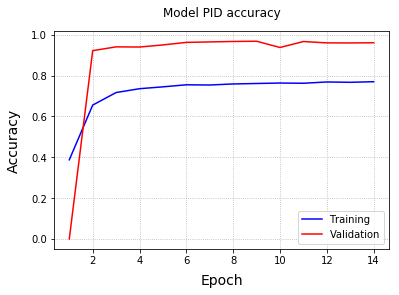

In [12]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
fig5.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


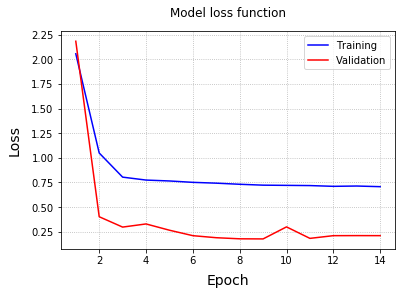

In [13]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')
plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
fig6.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


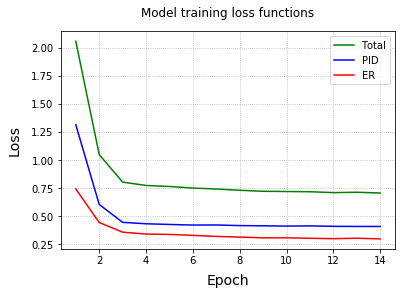

In [14]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')


plt.title('Model training loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
fig7.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


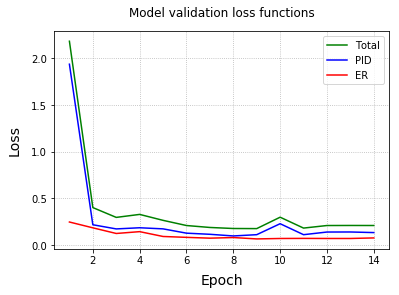

In [15]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')


plt.title('Model validation loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
fig8.show()